## Generate geoJSON files for contours of inundation map

### First import some necessary tools
Note: you'll need to install the geojson module to run this notebook. If you have pip you can simply run
>pip install geojson

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import print_function
from ptha_paths import data_dir, events_dir
import sys, os
from matplotlib import _cntr as cntr
from geojson import MultiPolygon, Feature, FeatureCollection, dump

Assuming that top level of this repository is at: /media/brian/TBdrive/Documents/Coursework/CSE512/Homework/project/tsunami-inundation/ptha_tutorial
    Python codes can be found in codes_dir = /media/brian/TBdrive/Documents/Coursework/CSE512/Homework/project/tsunami-inundation/ptha_tutorial/PythonCode
    Data files can be found in data_dir = /media/brian/TBdrive/Documents/Coursework/CSE512/Homework/project/tsunami-inundation/ptha_tutorial/DataFiles
    Results for each event can be found in events_dir = /media/brian/TBdrive/Documents/Coursework/CSE512/Homework/project/tsunami-inundation/ptha_tutorial/DataFiles/Events


### Set parameters 

In [3]:
# Parameters
events = ['CSZa']     # The events to consider
num_levels = 5        # The number of levels to partition inundation into

### Read in the topography data and compute zeta-clines

In [4]:
# Read in topography data:
nx = 250
ny = 250

fixed_grid_file = os.path.join(data_dir, 'MapsTopo', 'fixedgrid_xyB_small.npy')
d=load(fixed_grid_file)
x=d[:,0] - 360   # Longitudes
y=d[:,1]         # Latitudes
B=d[:,2]         # Bathymetry (topography in the absence of water)
topo = reshape(B, (nx,ny), order='F')
X = reshape(x, (nx,ny), order='F')
Y = reshape(y, (nx,ny), order='F')

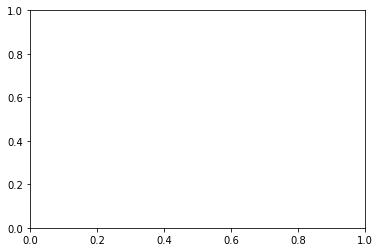

In [23]:
zeta_level_values = [1.e-3] +  list(linspace(0.5,4.5,num_levels-1))
event = events[0];
event_dir = os.path.join(events_dir, event)
hmax_file = os.path.join(event_dir, 'h_eta_small.npy')
hmax = load(hmax_file)
Hmax = hmax.reshape((nx,ny),order='F')
features = [None] * num_levels

k = 0;

# Go from largest values to smallest to get appropriate overlapping
zeta_cline_arr = Hmax > zeta_level_values[num_levels-k-1]
c = cntr.Cntr(X,Y,Hmax)
mylvl = zeta_level_values[num_levels-k-1]



fig = figure(figsize=(12, 8))
contour(X,Y,Hmax,[mylvl]) # contours based on floating point data
title('Contours from floating point data')
figure(figsize=(12, 8))
contour(X,Y,zeta_cline_arr,[0]) # contours based on binary data
title('Contours from binary data')

    


22

In [26]:
zeta_level_values = [1.e-3] +  list(linspace(0.5,4.5,num_levels-1))
# zeta_cline_arrays = empty((nx,ny,num_levels))


# Loop over all events and compute zeta clines for each
# Collect zeta clines for each level in multi-polygon environments
for event in events:
    event_dir = os.path.join(events_dir, event)
    hmax_file = os.path.join(event_dir, 'h_eta_small.npy')
    hmax = load(hmax_file)
    Hmax = hmax.reshape((nx,ny),order='F')
    features = [None] * num_levels
    c = cntr.Cntr(X,Y,Hmax)
    for k in xrange(num_levels):
        # Go from largest values to smallest to get appropriate overlapping
#         zeta_cline_arr = Hmax > zeta_level_values[num_levels-k-1]
#         c = cntr.Cntr(X,Y,zeta_cline_arr)
#         contours = c.trace(0)
        contours = c.trace(num_levels-k-1)
        num_paths = len(contours) // 2   # Half of the entries correspond to path connection types
        path_list = [poly.tolist() for poly in contours[:num_paths]]
        multi_poly = MultiPolygon([path_list])
        features[num_levels-k-1] = Feature(geometry=multi_poly)
        
    feature_collection = FeatureCollection(features)
    json_file = os.path.join(event_dir, 'contours.geojson')
    
    # Write to a file
    with open(json_file, 'w') as outfile:
        dump(feature_collection,outfile)
    
        
        
        

# Contour solution found here:
# https://stackoverflow.com/questions/18304722/python-find-contour-lines-from-matplotlib-pyplot-contour

In [111]:
# Some old code from debugging

# c = cntr.Cntr(X,Y,zeta_cline_arrays[:,:,2])
# res = c.trace(0)
# num_paths = len(res) // 2
# res_list = [poly.tolist() for poly in res[:num_paths]]